In [32]:
import pandas as pd
import json
import os
import ast
import seaborn as sns
import matplotlib.pyplot as plt


In [33]:
# Load JSON data (assuming it's saved as 'results.json')
with open('gpt_logprob_benchmark.json', 'r') as f:
    data = json.load(f)

# Transform JSON data into a DataFrame
# Parsing each entry and extracting relevant information
parsed_data = []

for question in data:
    # Extracting correct answer, generated token, and probabilities
    correct_answer = question[list(question.keys())[0]  ]
    token_data = question["tokens"][0]
    generated_token = token_data["generated_token"]
    log_probability = token_data["log_probability"]
    linear_probability = token_data["linear_probability"]
    
    # Extracting top alternatives
    top_alternatives = token_data["top_alternatives"]
    
    parsed_data.append({
        "correct_answer": correct_answer,
        "generated_token": generated_token,
        "log_probability": log_probability,
        "linear_probability": linear_probability,
        "top_alternatives": top_alternatives
    })

# Convert the parsed data to a DataFrame
df = pd.DataFrame(parsed_data)
df.head()


,correct_answer,generated_token,log_probability,linear_probability,top_alternatives
0,C,C,-0.000031,99.996893,"[{'token': 'C', 'log_probability': -3.106736e-..."
1,B,B,-0.001463,99.853774,"[{'token': 'B', 'log_probability': -0.00146333..."
2,D,D,-0.000554,99.944629,"[{'token': 'D', 'log_probability': -0.00055386..."
3,C,D,-0.004336,99.567386,"[{'token': 'D', 'log_probability': -0.00433552..."
4,B,B,-0.000253,99.974668,"[{'token': 'B', 'log_probability': -0.00025335..."


In [34]:

# Check if `top_alternatives` entries are strings, and apply `literal_eval` only if needed
def safe_literal_eval(val):
    if isinstance(val, str):  # Only apply ast.literal_eval if the entry is a string
        return ast.literal_eval(val)
    return val  # Return as is if it's already a list

# Apply the function to the `top_alternatives` column
df['top_alternatives'] = df['top_alternatives'].apply(safe_literal_eval)


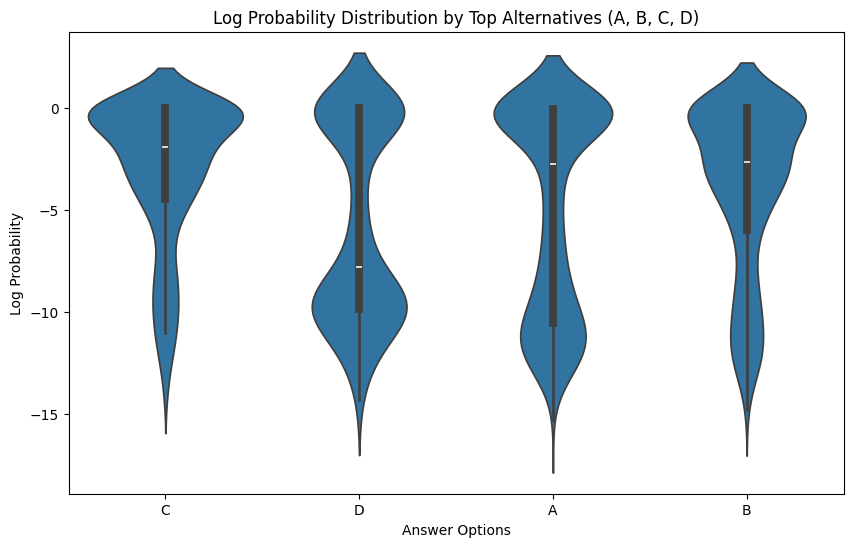

In [35]:

# Flatten top alternatives data to prepare for plotting
log_probs_data = []
for _, row in df.iterrows():
    for alt in row['top_alternatives']:
        log_probs_data.append({'Token': alt['token'], 'Log Probability': alt['log_probability']})

# Create DataFrame for plotting
log_probs_df = pd.DataFrame(log_probs_data)

# Filter for only 'A', 'B', 'C', and 'D' tokens
filtered_log_probs_df = log_probs_df[log_probs_df['Token'].isin(['A', 'B', 'C', 'D'])]

# Plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='Token', y='Log Probability', data=filtered_log_probs_df)
plt.title('Log Probability Distribution by Top Alternatives (A, B, C, D)')
plt.xlabel('Answer Options')
plt.ylabel('Log Probability')
plt.show()



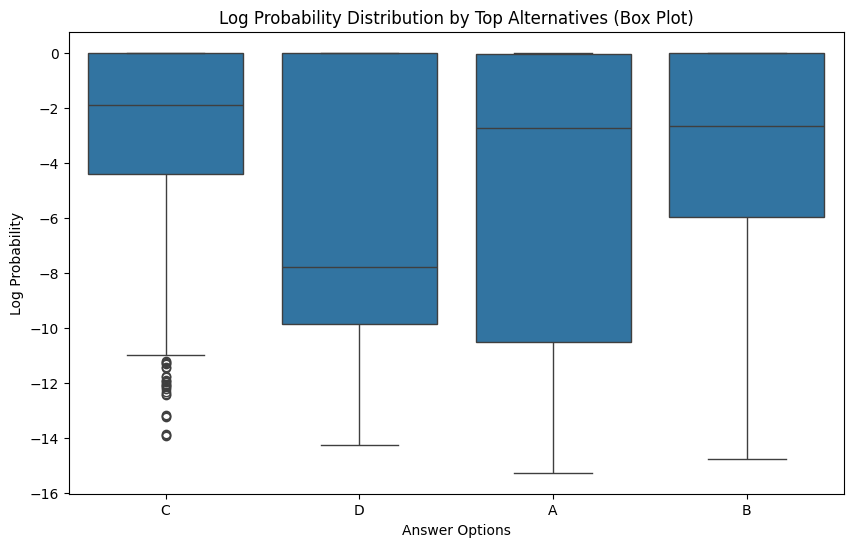

In [36]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Token', y='Log Probability', data=filtered_log_probs_df)
plt.title('Log Probability Distribution by Top Alternatives (Box Plot)')
plt.xlabel('Answer Options')
plt.ylabel('Log Probability')
plt.show()


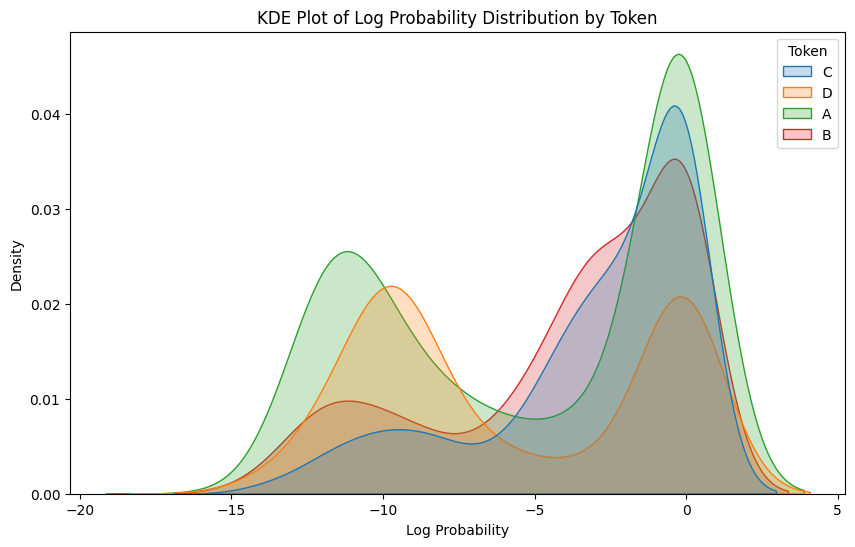

In [37]:

plt.figure(figsize=(10, 6))
sns.kdeplot(data=filtered_log_probs_df, x="Log Probability", hue="Token", fill=True)
plt.title('KDE Plot of Log Probability Distribution by Token')
plt.xlabel('Log Probability')
plt.ylabel('Density')
plt.show()


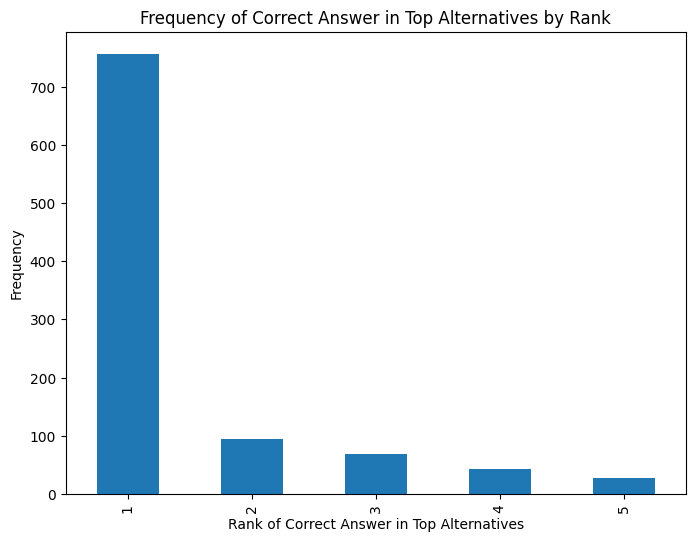

In [38]:
# List to store the rank of the correct answer in top alternatives
correct_in_alternatives = []

for _, row in df.iterrows():
    correct = row['correct_answer']
    alternatives = [alt['token'] for alt in row['top_alternatives']]
    if correct in alternatives:
        correct_in_alternatives.append(alternatives.index(correct) + 1)

# Convert to DataFrame for plotting
correct_rank_counts = pd.Series(correct_in_alternatives).value_counts().sort_index()
plt.figure(figsize=(8, 6))
correct_rank_counts.plot(kind='bar')
plt.xlabel('Rank of Correct Answer in Top Alternatives')
plt.ylabel('Frequency')
plt.title('Frequency of Correct Answer in Top Alternatives by Rank')
plt.show()


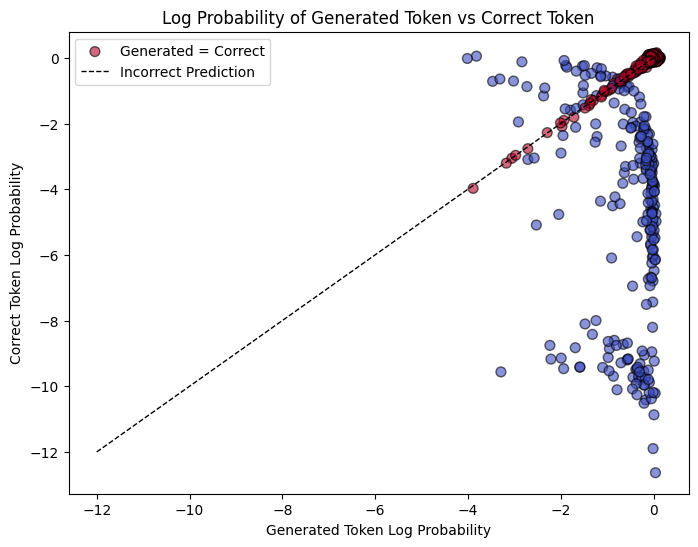

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

generated_logprobs = []
correct_logprobs = []
match_status = []  # Track whether the prediction was correct or not

for _, row in df.iterrows():
    generated_logprobs.append(row['log_probability'])
    correct = row['correct_answer']
    correct_alt = next((alt for alt in row['top_alternatives'] if alt['token'] == correct), None)
    correct_logprob = correct_alt['log_probability'] if correct_alt else np.nan  # Replace None with np.nan
    correct_logprobs.append(correct_logprob)
    match_status.append(row['generated_token'] == correct)  # True if correct, False otherwise

# Create a DataFrame to filter out NaN values
plot_data = pd.DataFrame({
    "Generated Log Probability": generated_logprobs,
    "Correct Log Probability": correct_logprobs,
    "Match Status": match_status
}).dropna()  # Remove rows where Correct Log Probability is NaN

# Create the plot
plt.figure(figsize=(8, 6))

# Scatter plot with color by match status and jitter for overlapping points
plt.scatter(
    plot_data["Generated Log Probability"] + np.random.normal(0, 0.05, len(plot_data)),  # Jitter on x-axis
    plot_data["Correct Log Probability"] + np.random.normal(0, 0.05, len(plot_data)),     # Jitter on y-axis
    c=plot_data["Match Status"], cmap="coolwarm", alpha=0.6, edgecolor='k', s=50
)

# Add a diagonal reference line (y=x)
plt.plot([-12, 0], [-12, 0], 'k--', linewidth=1, label='Generated = Correct')

# Labels and title
plt.xlabel("Generated Token Log Probability")
plt.ylabel("Correct Token Log Probability")
plt.title("Log Probability of Generated Token vs Correct Token")

# Legend for match status
plt.legend(['Generated = Correct', 'Incorrect Prediction', 'Correct Prediction'], loc='upper left')

plt.show()
